### Import libraries

In [38]:
#Import the required Python libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn .svm import SVR
from lightgbm import LGBMRegressor

### Import solar output dataset

In [39]:
data = pd.read_csv('./PV_Output_Hannover_MA.csv')

In [40]:
#Reading the solar output data measure as %baseline
data.head(5)

,Timestamp,% Baseline,City,County,State
0,"Jan 1, 2014 7am",0.0079,Hanover,Plymouth,Massachusetts
1,"Jan 1, 2014 8am",0.1019,Hanover,Plymouth,Massachusetts
2,"Jan 1, 2014 9am",0.3932,Hanover,Plymouth,Massachusetts
3,"Jan 1, 2014 10am",0.5447,Hanover,Plymouth,Massachusetts
4,"Jan 1, 2014 11am",0.5485,Hanover,Plymouth,Massachusetts


In [41]:
del data['City']
del data['County']
del data['State']

In [42]:
#Change Timestamp column to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

### Making an API call to www.worldweatheronline.com to retrieve weather data for Hanover, Massachusetts location between 2014 and 2018

In [43]:
#Retrieving weather data from www.worldweatheronline.com into pandas dataframe and csv.
# from wwo_hist import retrieve_hist_data
# import os
# #writing csv file to the output folder
# os.chdir("./output")
# frequency = 1
# start_date = '01-JAN-2014'
# end_date = '03-05-2018'
# api_key = 'YOUR_API_KEY'
# location_list = ['02340']
# hist_weather_data = retrieve_hist_data(api_key,
#                                 location_list,
#                                 start_date,
#                                 end_date,
#                                 frequency,
#                                 location_label = False,
#                                 export_csv = True,
#                                 store_df = True)

In [44]:
weather_df = pd.read_csv('./output/02340.csv')

In [45]:
weather_df.head(5)

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,2014-01-01 00:00:00,-3,-6,0.0,8.7,2,1,06:58 AM,05:05 PM,07:12 AM,...,28,3,58,0.0,1022,-4,10,273,20,2340
1,2014-01-01 01:00:00,-3,-6,0.0,8.7,2,1,06:58 AM,05:05 PM,07:12 AM,...,31,4,58,0.0,1023,-5,10,274,22,2340
2,2014-01-01 02:00:00,-3,-6,0.0,8.7,2,1,06:58 AM,05:05 PM,07:12 AM,...,34,5,58,0.0,1024,-5,10,276,25,2340
3,2014-01-01 03:00:00,-3,-6,0.0,8.7,2,1,06:58 AM,05:05 PM,07:12 AM,...,36,6,58,0.0,1024,-5,10,278,27,2340
4,2014-01-01 04:00:00,-3,-6,0.0,8.7,2,1,06:58 AM,05:05 PM,07:12 AM,...,32,9,57,0.0,1025,-6,10,271,23,2340


In [46]:
#Change date_time column to datetime
weather_df['date_time'] = pd.to_datetime(weather_df['date_time'])
#Deleting some of the columns
del weather_df['location']
del weather_df['moonrise']
del weather_df['moonset']
del weather_df['sunrise']
del weather_df['sunset']
del weather_df['pressure']

In [47]:
#Merging weather data with the original solar output data
outcome = pd.merge(data, weather_df, how='left', left_on='Timestamp', right_on='date_time')

In [48]:
del outcome['date_time']

In [49]:
outcome.head(5)

,Timestamp,% Baseline,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,tempC,visibility,winddirDegree,windspeedKmph
0,2014-01-01 07:00:00,0.0079,-3,-6,0.0,8.7,2,1,-14,-13,-5,-13,24,13,52,0.0,-5,10,262,18
1,2014-01-01 08:00:00,0.1019,-3,-6,0.0,8.7,2,1,-14,-12,-5,-12,26,11,49,0.0,-5,10,266,20
2,2014-01-01 09:00:00,0.3932,-3,-6,0.0,8.7,2,1,-14,-11,-4,-11,27,9,46,0.0,-4,10,270,22
3,2014-01-01 10:00:00,0.5447,-3,-6,0.0,8.7,2,1,-14,-10,-4,-10,25,15,46,0.0,-4,10,273,21
4,2014-01-01 11:00:00,0.5485,-3,-6,0.0,8.7,2,1,-14,-10,-3,-10,23,21,45,0.0,-3,10,276,19


### Reading Solar Irradiance datasets from https://nsrdb.nrel.gov/ for 2014, 2015, 2016, 2017 and 2018

In [50]:
# Reading Solar irradiance data for the year 2014 from National Solar Radiation Database
df1= pd.read_csv('./Weather_data_2014.csv')

In [51]:
#df1

In [52]:
# Reading Solar irradiance data for the year 2015 from National Solar Radiation Database
df2= pd.read_csv('./Weather_data_2015.csv')

In [53]:
#df2

In [54]:
# Reading Solar irradiance data for the year 2016 from National Solar Radiation Database
df3= pd.read_csv('./Weather_data_2016.csv')

In [55]:
#df3

In [56]:
# Reading Solar irradiance data for the year 2017 from National Solar Radiation Database
df4= pd.read_csv('./Weather_data_2017.csv')

In [57]:
#df4

In [58]:
# Reading Solar irradiance data for the year 2018 from National Solar Radiation Database
df5= pd.read_csv('./Weather_data_2018.csv')

In [59]:
#df5

In [60]:
#Stacking all the Solar irradiance data into one dataframe 
result = pd.concat([df1,df2, df3, df4, df5], ignore_index=True)

In [61]:
result.head(5)

,Year,Month,Day,Hour,Minute,DHI,DNI,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,Solar Zenith Angle,Fill Flag,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure
0,2014,1,1,0,0,0,0,0,0,0,0,1,-6.0,124.02,0,0.12,3.5,78.43,-3.0,1010
1,2014,1,1,1,0,0,0,0,0,0,0,1,-5.0,135.09,0,0.12,3.8,81.74,-3.0,1010
2,2014,1,1,2,0,0,0,0,0,0,0,1,-5.0,145.77,0,0.12,4.2,81.25,-3.0,1010
3,2014,1,1,3,0,0,0,0,0,0,0,1,-6.0,155.07,0,0.12,4.5,74.14,-3.0,1010
4,2014,1,1,4,0,0,0,0,0,0,0,1,-8.0,160.55,0,0.12,4.6,72.80,-4.0,1010


In [62]:
#Combining Year Month Day Hour Minute column into a single datatime column(easy to merge on the date_time column with 
#the final dataframe)
result['date_time']= pd.to_datetime(result[['Year', 'Month', 'Day', 'Hour', 'Minute']])
#Delete the individual columns after combining
del result['Year']
del result['Month']
del result['Day']
del result['Hour']
del result['Minute']

In [63]:
#Merge the final dataframe with the above Solar irradiance data
merged_df = pd.merge(outcome, result, how='left', left_on='Timestamp', right_on='date_time')

In [64]:
del merged_df['date_time']

In [65]:
#Deleting duplicate columns from the dataset
merged_df['Year'] = merged_df['Timestamp'].dt.year
merged_df['Month'] = merged_df['Timestamp'].dt.month
merged_df['Day'] = merged_df['Timestamp'].dt.day
merged_df['Hour'] = merged_df['Timestamp'].dt.hour
merged_df['Minute'] = merged_df['Timestamp'].dt.minute

In [66]:
del merged_df['Timestamp']
del merged_df['DewPointC']

In [67]:
merged_df.head(5)

,% Baseline,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,FeelsLikeC,HeatIndexC,WindChillC,...,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure,Year,Month,Day,Hour,Minute
0,0.0079,-3,-6,0.0,8.7,2,1,-13,-5,-13,...,0.12,4.4,69.95,-5.0,1020,2014,1,1,7,0
1,0.1019,-3,-6,0.0,8.7,2,1,-12,-5,-12,...,0.12,4.3,74.24,-6.0,1020,2014,1,1,8,0
2,0.3932,-3,-6,0.0,8.7,2,1,-11,-4,-11,...,0.12,4.3,73.07,-6.0,1020,2014,1,1,9,0
3,0.5447,-3,-6,0.0,8.7,2,1,-10,-4,-10,...,0.12,4.1,72.43,-6.0,1020,2014,1,1,10,0
4,0.5485,-3,-6,0.0,8.7,2,1,-10,-3,-10,...,0.12,3.9,72.47,-6.0,1020,2014,1,1,11,0


In [68]:
# view summary of dataset
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20571 entries, 0 to 20570
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   % Baseline          20571 non-null  float64
 1   maxtempC            20571 non-null  int64  
 2   mintempC            20571 non-null  int64  
 3   totalSnow_cm        20571 non-null  float64
 4   sunHour             20571 non-null  float64
 5   uvIndex             20571 non-null  int64  
 6   moon_illumination   20571 non-null  int64  
 7   FeelsLikeC          20571 non-null  int64  
 8   HeatIndexC          20571 non-null  int64  
 9   WindChillC          20571 non-null  int64  
 10  WindGustKmph        20571 non-null  int64  
 11  cloudcover          20571 non-null  int64  
 12  humidity            20571 non-null  int64  
 13  precipMM            20571 non-null  float64
 14  tempC               20571 non-null  int64  
 15  visibility          20571 non-null  int64  
 16  wind

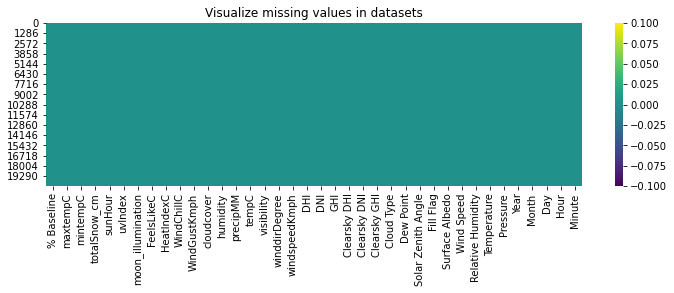

In [69]:
plt.figure(figsize=(12, 3))
sns.heatmap(merged_df.isnull(), cmap='viridis');
plt.title('Visualize missing values in datasets');

In [70]:
# view summary statistics in numerical variables
round(merged_df.describe(),2)

,% Baseline,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,FeelsLikeC,HeatIndexC,WindChillC,...,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure,Year,Month,Day,Hour,Minute
count,20571.00,20571.00,20571.00,20571.00,20571.00,20571.00,20571.00,20571.00,20571.00,20571.00,...,20571.00,20571.00,20571.00,20571.00,20571.00,20571.00,20571.00,20571.00,20571.00,20571.0
mean,0.24,14.76,8.36,0.12,10.41,3.77,50.25,10.83,12.89,10.54,...,0.21,2.59,81.44,10.87,1007.63,2015.55,6.42,15.73,11.98,0.0
std,0.25,9.53,8.56,0.85,3.40,1.74,28.91,11.74,9.74,11.37,...,0.23,1.33,16.97,9.48,8.76,1.17,3.24,8.86,4.21,0.0
min,0.00,-12.00,-20.00,0.00,3.40,1.00,0.00,-32.00,-20.00,-32.00,...,0.11,0.10,30.31,-19.00,970.00,2014.00,1.00,1.00,0.00,0.0
25%,0.03,7.00,2.00,0.00,8.70,2.00,25.00,2.00,5.00,2.00,...,0.12,1.60,68.30,3.00,1000.00,2015.00,4.00,8.00,8.00,0.0
50%,0.13,15.00,9.00,0.00,11.20,4.00,50.00,12.00,13.00,12.00,...,0.13,2.40,85.21,11.00,1010.00,2016.00,6.00,16.00,12.00,0.0
75%,0.39,23.00,16.00,0.00,13.50,5.00,75.00,20.00,21.00,20.00,...,0.14,3.30,97.75,19.00,1010.00,2017.00,9.00,23.00,15.00,0.0
max,1.02,32.00,23.00,22.20,14.50,7.00,100.00,36.00,36.00,32.00,...,0.87,11.00,100.00,32.00,1040.00,2018.00,12.00,31.00,21.00,0.0


In [71]:
del merged_df['Minute']

In [72]:
# checking the correlation matrix between the predictors and the dependent variable of capacity_factor
corr_test = merged_df[['% Baseline', 'maxtempC','mintempC','totalSnow_cm','sunHour','uvIndex','moon_illumination',
              'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity',
              'precipMM','tempC', 'visibility', 'winddirDegree', 'windspeedKmph','DHI','DNI','GHI','Clearsky DHI','Clearsky DNI','Clearsky GHI','Cloud Type','Dew Point','Solar Zenith Angle','Fill Flag','Surface Albedo','Wind Speed','Relative Humidity',
                     'Temperature','Pressure', 'Year','Month','Day','Hour']]
corr = corr_test.corr()
corr.style.background_gradient(cmap='Greens').set_precision(2)

,% Baseline,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,tempC,visibility,winddirDegree,windspeedKmph,DHI,DNI,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,Solar Zenith Angle,Fill Flag,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure,Year,Month,Day,Hour
% Baseline,1.00,0.22,0.17,-0.08,0.37,0.24,0.02,0.32,0.33,0.32,-0.13,-0.33,-0.57,-0.12,0.33,0.21,-0.01,-0.06,0.08,0.31,0.22,0.12,0.20,0.13,-0.28,0.12,-0.27,0.01,-0.15,-0.16,-0.14,0.17,0.07,-0.02,-0.02,0.01,0.01
maxtempC,0.22,1.00,0.96,-0.19,0.68,0.93,-0.01,0.97,0.97,0.97,-0.18,-0.27,0.00,0.02,0.97,0.22,-0.12,-0.30,0.23,0.10,0.25,0.21,0.10,0.22,-0.14,0.94,-0.27,-0.09,-0.51,-0.51,-0.01,0.94,-0.18,-0.06,0.38,0.02,0.07
mintempC,0.17,0.96,1.00,-0.19,0.60,0.88,-0.02,0.96,0.96,0.96,-0.17,-0.17,0.07,0.04,0.96,0.18,-0.20,-0.27,0.23,0.05,0.20,0.21,0.09,0.21,-0.08,0.96,-0.26,-0.09,-0.55,-0.46,0.04,0.94,-0.20,-0.04,0.42,0.02,0.07
totalSnow_cm,-0.08,-0.19,-0.19,1.00,-0.17,-0.19,0.05,-0.19,-0.18,-0.19,0.07,0.13,0.08,0.18,-0.19,-0.27,0.03,0.09,-0.04,-0.05,-0.06,-0.01,-0.03,-0.04,0.09,-0.16,0.04,0.03,0.24,0.10,0.02,-0.17,-0.03,0.01,-0.11,-0.05,-0.01
sunHour,0.37,0.68,0.60,-0.17,1.00,0.70,0.03,0.64,0.64,0.64,-0.22,-0.57,-0.28,-0.13,0.64,0.32,0.02,-0.29,0.24,0.29,0.38,0.21,0.17,0.29,-0.33,0.55,-0.31,-0.09,-0.31,-0.41,-0.23,0.63,-0.06,-0.10,0.01,0.01,0.08
uvIndex,0.24,0.93,0.88,-0.19,0.70,1.00,0.01,0.90,0.90,0.90,-0.21,-0.35,-0.09,-0.02,0.90,0.25,-0.08,-0.31,0.21,0.15,0.27,0.19,0.10,0.22,-0.20,0.84,-0.26,-0.08,-0.42,-0.49,-0.10,0.87,-0.09,-0.05,0.35,0.03,0.07
moon_illumination,0.02,-0.01,-0.02,0.05,0.03,0.01,1.00,-0.01,-0.01,-0.01,0.02,-0.05,-0.04,0.01,-0.01,0.03,0.05,0.01,-0.01,0.03,0.02,-0.00,0.00,-0.00,-0.02,-0.02,0.01,0.02,0.04,0.02,-0.02,-0.02,0.08,0.01,-0.00,-0.16,-0.00
FeelsLikeC,0.32,0.97,0.96,-0.19,0.64,0.90,-0.01,1.00,0.99,1.00,-0.22,-0.23,-0.04,0.02,1.00,0.23,-0.17,-0.33,0.25,0.13,0.26,0.24,0.15,0.25,-0.13,0.93,-0.32,-0.08,-0.52,-0.54,-0.01,0.93,-0.15,-0.05,0.39,0.02,0.09
HeatIndexC,0.33,0.97,0.96,-0.18,0.64,0.90,-0.01,0.99,1.00,0.99,-0.17,-0.23,-0.05,0.03,1.00,0.21,-0.15,-0.27,0.25,0.13,0.26,0.24,0.15,0.25,-0.13,0.93,-0.32,-0.08,-0.50,-0.50,-0.01,0.93,-0.17,-0.04,0.38,0.02,0.09
WindChillC,0.32,0.97,0.96,-0.19,0.64,0.90,-0.01,1.00,0.99,1.00,-0.22,-0.23,-0.04,0.02,1.00,0.23,-0.18,-0.33,0.25,0.13,0.26,0.24,0.15,0.25,-0.13,0.93,-0.32,-0.08,-0.53,-0.54,-0.01,0.93,-0.15,-0.05,0.40,0.02,0.09


#### Feature Engineering 

In [73]:
merged_df['Hour'].unique()

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,  6, 18,  5, 19, 20,  4,
       21,  0,  1,  2,  3], dtype=int64)

In [74]:
merged_df['Month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [75]:
max_hour = merged_df['Hour'].max()
max_hour

21

In [76]:
# Create Cyclic date features
merged_df['Hour_sin'] = np.sin(2 * np.pi * merged_df['Hour']/max_hour)
merged_df['Hour_cos'] = np.cos(2 * np.pi * merged_df['Hour']/max_hour)
merged_df['sine_mon']= np.sin((merged_df.Month - 1)*np.pi/12)
merged_df['cos_mon']= np.cos((merged_df.Month - 1)*np.pi/12)

In [77]:
del merged_df['Hour']
del merged_df['Month']

In [78]:
merged_df

,% Baseline,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,FeelsLikeC,HeatIndexC,WindChillC,...,Wind Speed,Relative Humidity,Temperature,Pressure,Year,Day,Hour_sin,Hour_cos,sine_mon,cos_mon
0,0.0079,-3,-6,0.0,8.7,2,1,-13,-5,-13,...,4.4,69.95,-5.0,1020,2014,1,0.866025,-0.500000,0.0,1.000000
1,0.1019,-3,-6,0.0,8.7,2,1,-12,-5,-12,...,4.3,74.24,-6.0,1020,2014,1,0.680173,-0.733052,0.0,1.000000
2,0.3932,-3,-6,0.0,8.7,2,1,-11,-4,-11,...,4.3,73.07,-6.0,1020,2014,1,0.433884,-0.900969,0.0,1.000000
3,0.5447,-3,-6,0.0,8.7,2,1,-10,-4,-10,...,4.1,72.43,-6.0,1020,2014,1,0.149042,-0.988831,0.0,1.000000
4,0.5485,-3,-6,0.0,8.7,2,1,-10,-3,-10,...,3.9,72.47,-6.0,1020,2014,1,-0.149042,-0.988831,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20566,0.2325,4,1,0.0,5.7,1,79,-2,4,-2,...,5.5,87.86,1.9,1010,2018,5,-0.680173,-0.733052,0.5,0.866025
20567,0.2214,4,1,0.0,5.7,1,79,-1,4,-1,...,5.6,84.15,2.5,1010,2018,5,-0.866025,-0.500000,0.5,0.866025
20568,0.3111,4,1,0.0,5.7,1,79,-1,4,-1,...,5.7,79.86,3.2,1010,2018,5,-0.974928,-0.222521,0.5,0.866025
20569,0.0810,4,1,0.0,5.7,1,79,-2,4,-2,...,5.7,76.97,3.7,1010,2018,5,-0.997204,0.074730,0.5,0.866025


In [79]:
mask2 = np.triu(np.ones_like(merged_df.corr(), dtype=bool))

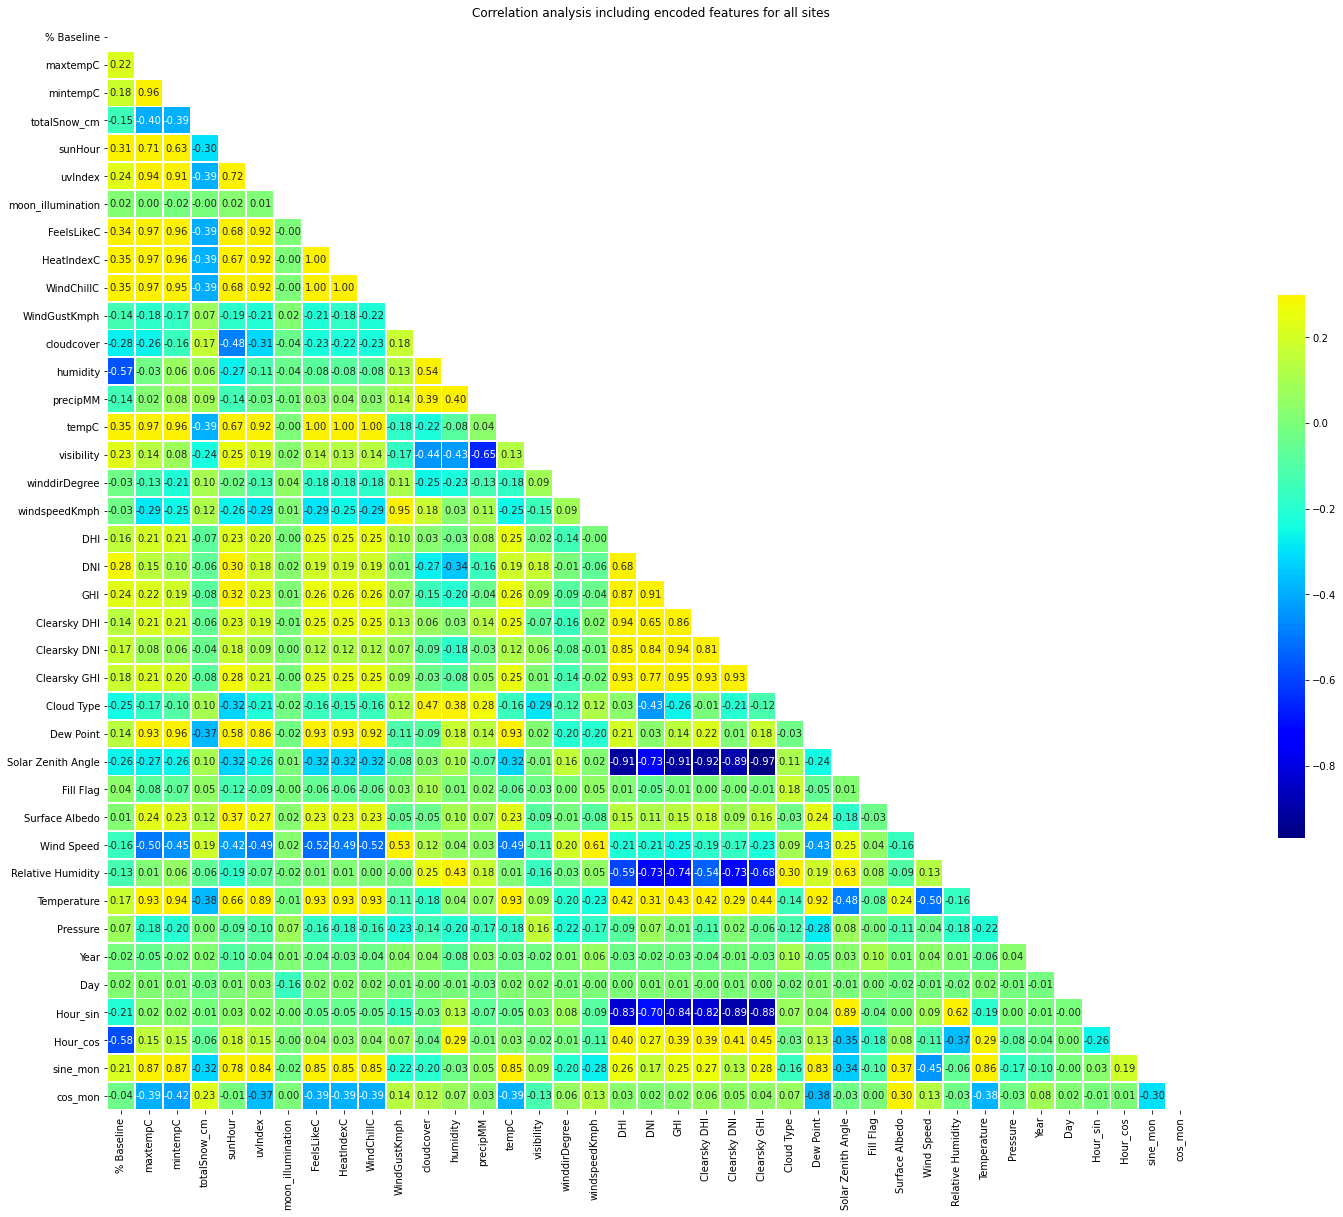

In [80]:
f, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(merged_df.corr(method='spearman'), mask=mask2, cmap='jet', vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.9, cbar_kws={"shrink": .5});
plt.title('Correlation analysis including encoded features for all sites');

In [81]:
merged_df

,% Baseline,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,FeelsLikeC,HeatIndexC,WindChillC,...,Wind Speed,Relative Humidity,Temperature,Pressure,Year,Day,Hour_sin,Hour_cos,sine_mon,cos_mon
0,0.0079,-3,-6,0.0,8.7,2,1,-13,-5,-13,...,4.4,69.95,-5.0,1020,2014,1,0.866025,-0.500000,0.0,1.000000
1,0.1019,-3,-6,0.0,8.7,2,1,-12,-5,-12,...,4.3,74.24,-6.0,1020,2014,1,0.680173,-0.733052,0.0,1.000000
2,0.3932,-3,-6,0.0,8.7,2,1,-11,-4,-11,...,4.3,73.07,-6.0,1020,2014,1,0.433884,-0.900969,0.0,1.000000
3,0.5447,-3,-6,0.0,8.7,2,1,-10,-4,-10,...,4.1,72.43,-6.0,1020,2014,1,0.149042,-0.988831,0.0,1.000000
4,0.5485,-3,-6,0.0,8.7,2,1,-10,-3,-10,...,3.9,72.47,-6.0,1020,2014,1,-0.149042,-0.988831,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20566,0.2325,4,1,0.0,5.7,1,79,-2,4,-2,...,5.5,87.86,1.9,1010,2018,5,-0.680173,-0.733052,0.5,0.866025
20567,0.2214,4,1,0.0,5.7,1,79,-1,4,-1,...,5.6,84.15,2.5,1010,2018,5,-0.866025,-0.500000,0.5,0.866025
20568,0.3111,4,1,0.0,5.7,1,79,-1,4,-1,...,5.7,79.86,3.2,1010,2018,5,-0.974928,-0.222521,0.5,0.866025
20569,0.0810,4,1,0.0,5.7,1,79,-2,4,-2,...,5.7,76.97,3.7,1010,2018,5,-0.997204,0.074730,0.5,0.866025


### Modeling 

#### Declare feature vector and target variable

In [82]:
X = merged_df.drop(['% Baseline'], axis=1)
y= merged_df['% Baseline']

In [83]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

#### Feature selection - Dropping features using Pearson Correlation

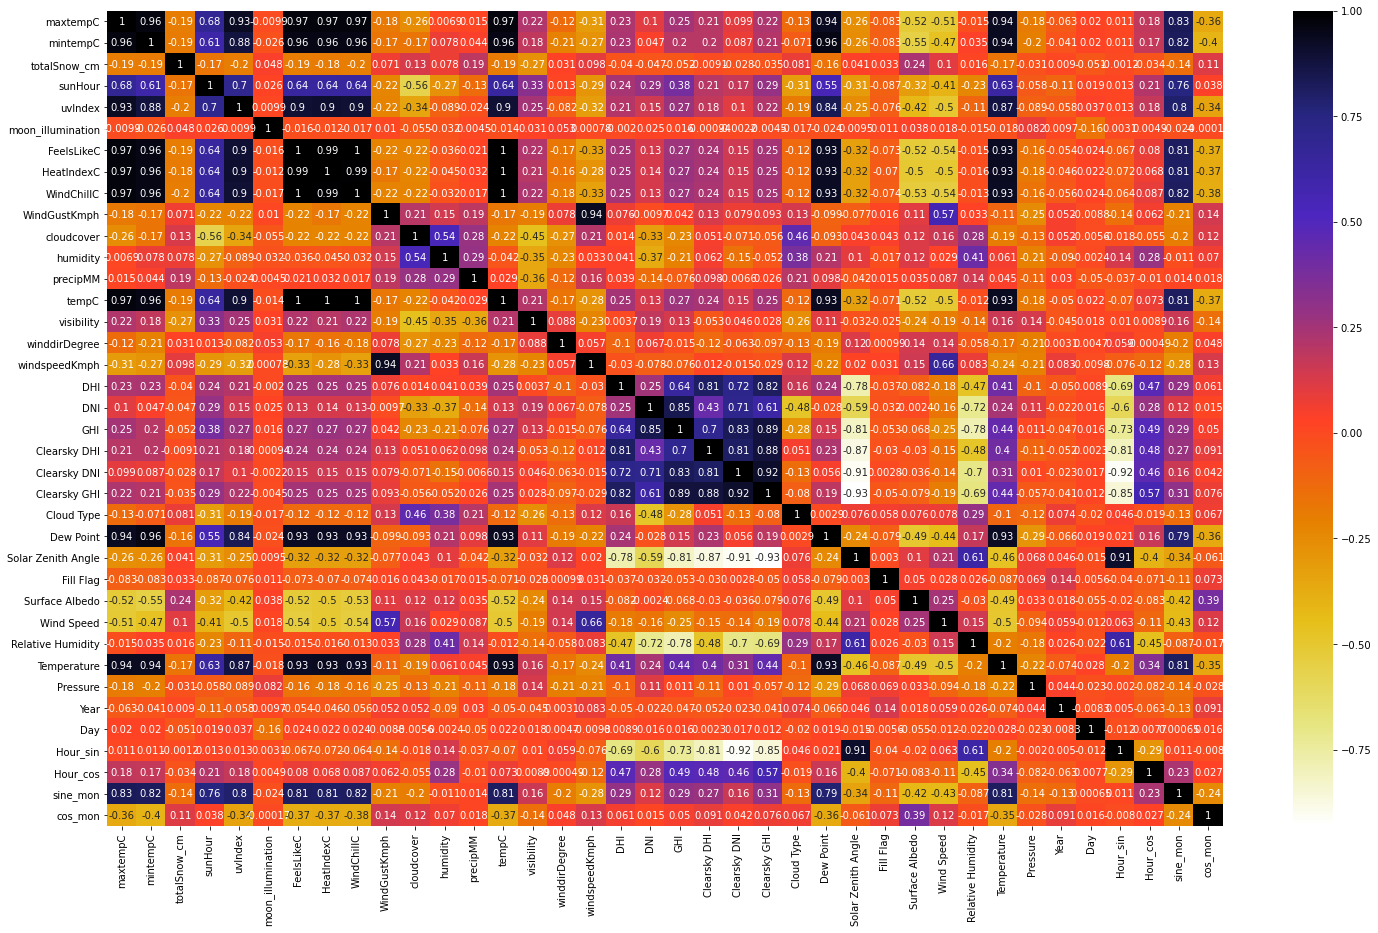

In [84]:
plt.figure(figsize=(25,15))
cor=X_train.corr()
sns.heatmap(cor,annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [85]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [86]:
corr_features = correlation(X_train, 0.9)
len(set(corr_features))

11

In [87]:
corr_features

{'Clearsky GHI',
 'Dew Point',
 'FeelsLikeC',
 'HeatIndexC',
 'Hour_sin',
 'Temperature',
 'WindChillC',
 'mintempC',
 'tempC',
 'uvIndex',
 'windspeedKmph'}

In [88]:
X_train.drop(corr_features, axis=1)
X_test.drop(corr_features, axis=1)

,maxtempC,totalSnow_cm,sunHour,moon_illumination,WindGustKmph,cloudcover,humidity,precipMM,visibility,winddirDegree,...,Fill Flag,Surface Albedo,Wind Speed,Relative Humidity,Pressure,Year,Day,Hour_cos,sine_mon,cos_mon
6439,14,0.0,12.2,64,27,67,65,0.0,9,219,...,0,0.123,4.8,94.20,1000,2015,28,-0.988831,0.707107,7.071068e-01
4315,16,0.0,5.5,16,24,74,85,0.1,10,130,...,4,0.128,2.5,96.85,1010,2014,21,-0.988831,0.707107,-7.071068e-01
11008,2,1.2,10.2,79,21,88,65,0.0,10,77,...,0,0.119,3.4,56.77,1010,2016,20,-0.222521,0.500000,8.660254e-01
292,-3,0.0,8.7,43,8,8,66,0.0,10,319,...,4,0.866,3.5,88.69,1010,2014,6,-0.900969,0.258819,9.659258e-01
15542,-1,0.0,8.7,53,32,6,56,0.0,10,297,...,0,0.119,4.9,76.60,1010,2017,4,-0.222521,0.258819,9.659258e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11332,13,0.0,13.1,28,66,46,58,0.0,10,202,...,0,0.119,4.1,74.71,1010,2016,11,-0.222521,0.707107,7.071068e-01
3727,21,0.0,12.9,93,20,53,61,0.0,10,73,...,0,0.136,2.9,53.20,1020,2014,8,-0.222521,0.866025,-5.000000e-01
7933,29,0.0,14.5,94,47,46,75,0.2,10,215,...,0,0.142,2.8,65.93,1000,2015,30,0.074730,1.000000,6.123234e-17
8559,32,0.0,12.9,35,20,6,63,0.0,10,242,...,0,0.130,2.4,94.92,1010,2015,8,-0.733052,0.866025,-5.000000e-01


### Model Stacking - Build base models with optimal hyperparameters

#### Nueral Network model set up 

In [89]:
os.environ['PYTHONHASHSEED'] = str(33)
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Dense, Conv1D, ReLU, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import backend as K

In [90]:
tf.random.set_seed(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

In [91]:
def dl_model(n_units1, n_units2, n_units3, act1, act2, act3, ker_init, lr, dr0, dr1, dl_loss):
    model = Sequential()
    model.add(Dense(n_units1, activation=act1, kernel_initializer=ker_init, input_dim=X_train.shape[1]))
    model.add(Dropout(dr0))
    model.add(Dense(n_units2, activation=act2, kernel_initializer=ker_init))
    model.add(Dropout(dr1))
    model.add(Dense(n_units3, activation=act3, kernel_initializer=ker_init))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=[r_squared, tf.keras.metrics.mean_squared_error], loss=dl_loss)
    return model

In [92]:
def custom_loss(y_true, y_pred):
    # (1-R2)
    SS_res = K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true-K.mean(y_true)))
    return SS_res/(SS_tot+K.epsilon())

In [93]:
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true-K.mean(y_true)))
    return (1-SS_res/(SS_tot+K.epsilon()))

#### Build NN training pipepline 

In [94]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
# Scale training data
estimators = []
estimators.append(('standardize', StandardScaler()))
kr_regressor = KerasRegressor(build_fn=dl_model)
kr_regressor._estimator_type = "regressor"
estimators.append(('kr', kr_regressor))
pipeline = Pipeline(estimators)

#### Train NN Model using optimal hyper-parameters from above

In [95]:
dl_best_params = {'kr__n_units3':320, 'kr__n_units2':240, 'kr__n_units1':280, 'kr__lr':0.001,
                  'kr__ker_init':tf.keras.initializers.GlorotUniform(seed=32), 'kr__epochs':70, 'kr__dr1':0.1, 'kr__dr0':0.1,
                  'kr__dl_loss':custom_loss,
                  'kr__batch_size':600, 'kr__act3':'tanh', 'kr__act2':'relu', 'kr__act1':'relu', 'kr__verbose':0}

In [96]:
dl_model = pipeline.set_params(**dl_best_params)

#### Build LGBM Model

In [97]:
lgbm_best_params = {'objective':'rmse', 'num_leaves':1400, 'n_estimators':900, 'max_depth':11, 'learning_rate':0.008,
                    'feature_fraction':0.6, 'random_state':42}

In [98]:
lgbm_model = LGBMRegressor(**lgbm_best_params)

#### Build RandomForest Model 

In [99]:
rf_best_params = {'max_features':'sqrt', 'min_samples_split':5, 'min_samples_leaf':2, 'n_estimators':1800, 'max_depth':20, 'bootstrap':True, 'random_state':42}

In [100]:
rf_model = RandomForestRegressor(**rf_best_params)

#### Build Meta learner Model 

In [101]:
# Scale training data
knn_estimators = []
knn_estimators.append(('knn_standardize', StandardScaler()))
# estimators.append(('minmax', MinMaxScaler()))
knn_estimators.append(('knn', KNeighborsRegressor()))
knn_pipeline = Pipeline(knn_estimators)

In [102]:
knn_best_params = {'knn__weights': 'distance', 'knn__p': 2, 'knn__n_neighbors': 15, 'knn__leaf_size': 30, 'knn__algorithm': 'ball_tree'}

In [103]:
knn_model = knn_pipeline.set_params(**knn_best_params)

In [104]:
# Define the base models
base0 = list()
base0.append(('dl', dl_model))
base0.append(('lgbm', lgbm_model))
base0.append(('rf', rf_model))
base0.append(('knn', knn_model))

In [105]:
# Define meta learner model
base1 = LinearRegression()

In [106]:
# Define the stacking ensemble
stacked_model = StackingRegressor(estimators=base0, final_estimator=base1, cv=4, passthrough=True)

In [107]:
%%time
# Fit the model on the training data
stacked_model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Wall time: 7min 33s


StackingRegressor(cv=4,
                  estimators=[('dl',
                               Pipeline(steps=[('standardize',
                                                StandardScaler()),
                                               ('kr',
                                                <keras.wrappers.scikit_learn.KerasRegressor object at 0x000002AE6B5E5FD0>)])),
                              ('lgbm',
                               LGBMRegressor(feature_fraction=0.6,
                                             learning_rate=0.008, max_depth=11,
                                             n_estimators=900, num_leaves=1400,
                                             objective='rmse',
                                             random_state=42)),
                              ('rf',
                               RandomForestRegressor(max_depth=20,
                                                     max_features='sqrt',
                                                     min_

#### Make model interferences on test set 

In [108]:
y_pred = stacked_model.predict(X_test)

In [109]:
y_pred

array([0.57826085, 0.14166691, 0.2615    , ..., 0.21510295, 0.15609888,
       0.08691361])

#### Evaluate model performance on test set

In [110]:
# Explained variance
explained_variance_score(y_test.ravel(), y_pred)

0.917766022403162

In [111]:
# R2 score
r2_score(y_test.ravel(), y_pred)

0.917190730902595

In [112]:
# Mean absolute error
mean_absolute_error(y_test.ravel(), y_pred)

0.04625457260405357

In [113]:
# Root mean square error
np.sqrt(mean_squared_error(y_test.ravel(), y_pred))

0.07382332911211552

In [114]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [115]:
mean_absolute_percentage_error(y_test.ravel(), y_pred)*100

30260.45146093585